In [4]:
library(gtools)
library(dplyr)
library(ggplot2)

Warning message:
"package 'gtools' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


In [17]:
# load data
inTeams<-read.csv("https://projects.fivethirtyeight.com/soccer-api/club/spi_global_rankings.csv")

In [18]:
# PRE SIMULATION WORK

In [19]:
# Prize dataframe
ranks <- 1:20
prizes <- matrix(ranks, nrow=20, ncol=1, byrow=FALSE)
prizes <- as.data.frame(prizes)
colnames(prizes) <- c('team_rank')
prizes$prize <- c(225,210,200,190,160,150,140,125,123,120,118,115,112,110,108,105,100,52,50,49)

In [20]:
# taking averages
mean.off<-mean(inTeams$off)
mean.def<-mean(inTeams$def)
lmean.off<-mean(log(inTeams$off))
lmean.def<-mean(log(inTeams$def)) 

# subset to premier league
premLeague<-subset(inTeams,league=="Barclays Premier League")
premTeams<-premLeague$name
rownames(premLeague)<-premTeams
df.prem<-premLeague[,c("off","def")]

# build parameters
lmean.def<- log(mean(df.prem$def))
lmean.off<- log(mean(df.prem$off))               
df.prem["alpha"]<-log(df.prem["off"])-lmean.def
df.prem["delta"]<-lmean.off-log(df.prem["def"])
alphaList<-df.prem$alpha
deltaList<-df.prem$delta
names(alphaList)<-rownames(df.prem)
names(deltaList)<-rownames(df.prem)

In [21]:
# simulate score line for a match
draw.score<-function(team1,team2){
    c(
        rpois(1,exp(alphaList[team1]-deltaList[team2])),
  rpois(1,exp(alphaList[team2]-deltaList[team1]))
    )
}
draw.score("Liverpool","Arsenal")

[1] 0 1

In [22]:
# All possible matches in a season
allMatches<-permutations(20, 2, v=rownames(df.prem),repeats.allowed=FALSE)
colnames(allMatches)<-c("home","away")
allMatches
nrow(allMatches)

home,away
Arsenal,Aston Villa
Arsenal,Brentford
Arsenal,Brighton and Hove Albion
Arsenal,Burnley
Arsenal,Chelsea
Arsenal,Crystal Palace
Arsenal,Everton
Arsenal,Leeds United
Arsenal,Leicester City
Arsenal,Liverpool


[1] 380

In [8]:
# SIMULATION

In [23]:
SeasonSim <- function(allMatches){
     ScoresMatrix <- matrix(nrow=nrow(allMatches),  ncol=4)
        for (ii in 1:nrow(allMatches)  ) {
         ScoresMatrix[ii,1:2]=allMatches[ii,]
         ScoresMatrix[ii,3:4]= as.numeric(draw.score(allMatches[ii,"home"],allMatches[ii,"away"] ))
        }
        colnames(ScoresMatrix)<-c("home.team","away.team","home.score","away.score")
        ScoresMatrix <- as.data.frame(ScoresMatrix)
        ScoresMatrix$home.score <- as.numeric(ScoresMatrix$home.score)
        ScoresMatrix$away.score <- as.numeric(ScoresMatrix$away.score)  
        
        # PREPARING AGGREGATE STATS DFs
        df.points <- as.data.frame(ScoresMatrix)
        df.points_goalsfor <- as.data.frame(ScoresMatrix)
        df.points_goalsagainst <- as.data.frame(ScoresMatrix)
        name <- rownames(df.prem)
        for (i in 1:20){
            df.points[, name[i]] <- 0
        }
        df.points

        # ASSIGNING POINTS PER MATCH
        for (i in 1:380){ 
            for (j in 1:20){
                if (df.points[i,1] == name[j]){
                    if (df.points[i,3] > df.points[i,4]){
                        df.points[i,j+4] = 3
                    } else if (df.points[i,3] == df.points[i,4]){
                        df.points[i,j+4] = 1
                    } else if (df.points[i,3] < df.points[i,4]){
                        df.points[i,j+4] = 0
                    } 
                } 
                if (df.points[i,2] == name[j]){
                    if (df.points[i,3] > df.points[i,4]){
                        df.points[i,j+4] = 0
                    } else if (df.points[i,3] == df.points[i,4]){
                        df.points[i,j+4] = 1
                    } else if (df.points[i,3] < df.points[i,4]){
                        df.points[i,j+4] = 3
                    }      
                }
            }   
        } 
    
        # PREPARING DFs
        for (i in 1:20){
            df.points_goalsfor[, name[i]] <- 0
        }
        for (i in 1:20){
            df.points_goalsagainst[, name[i]] <- 0
        }
    
        # GOALS FOR
        for (i in 1:380){
            for (j in 1:20){
                if (df.points_goalsfor[i,1] == name[j]){ # looking at home team
                    df.points_goalsfor[i,j+4] = df.points_goalsfor[i,3]  # home points go to goals for
                }
                if (df.points_goalsfor[i,2] == name[j]){ # looking at away team
                    df.points_goalsfor[i,j+4] = df.points_goalsfor[i,4] # away points go to goals for
                }
            }
        }
    
        # GOALS AGAINST
        for (i in 1:380){
            for (j in 1:20){
                if (df.points_goalsagainst[i,1] == name[j]){ # looking at home team
                    df.points_goalsagainst[i,j+4] = df.points_goalsagainst[i,4]  # home points go to goals for
                }
                if (df.points_goalsagainst[i,2] == name[j]){ # looking at away team
                    df.points_goalsagainst[i,j+4] = df.points_goalsagainst[i,3] # away points go to goals for
                }
            }
        } 
        
        # AGGREGATING POINTS and GOALS
        points <- df.points[,c(-1,-2,-3,-4)]
        points <- sapply(points, as.numeric)
        points_sum <- as.data.frame(colSums(points))
        
        goalsfor <- df.points_goalsfor[,c(-1,-2,-3,-4)]
        goalsfor <- sapply(goalsfor, as.numeric)
        goalsfor_sum <- as.data.frame(colSums(goalsfor))
    
        goalsagainst <- df.points_goalsagainst[,c(-1,-2,-3,-4)]
        goalsagainst <- sapply(goalsagainst, as.numeric)
        goalsagainst_sum <- as.data.frame(colSums(goalsagainst))

        # MERGE TO ONE DF
        df.teams <- cbind(points_sum, goalsfor_sum, goalsagainst_sum)
        colnames(df.teams)[1] <- 'points'
        colnames(df.teams)[2] <- 'goals_for'
        colnames(df.teams)[3] <- 'goals_against'
        df.teams$team_names <- row.names(df.teams)
    
        # ADD TIE BREAKER VARIABLES
        df.teams <- df.teams %>%
            mutate(net_goals = goals_for - goals_against) %>%
            mutate(tie_breaker = runif(20, 0, 1))
        df.teams1 <- df.teams
        df.teams1$temp_team_rank <- rank(desc(df.teams1$points))
        df.teams1$temp_team_rank2 <- rank(desc(df.teams1$points))
        df.teams1$goals_rank <- rank(desc(df.teams1$net_goals))
        df.teams1$goalsfor_rank <- rank(desc(df.teams1$goals_for))
        df.teams1
    
        # RANK 
        for (ii in 1:nrow(df.teams1)){
            for (jj in 1:nrow(df.teams1)){
                if (ii != jj & df.teams1[ii,7] == df.teams1[jj,7]){
                    if (df.teams1[ii,9] > df.teams1[jj,9]){ #goals rank
                        df.teams1[ii,8] = df.teams1[ii,8]+0.5
                        df.teams1[jj,8] = df.teams1[jj,8]-0.5
                    } else if (df.teams1[ii,9] == df.teams1[jj,9]){ 
                        if (df.teams1[ii,10] > df.teams1[jj,10]){ #goals_for rank
                            df.teams1[ii,8] = df.teams1[ii,8]+0.5
                            df.teams1[jj,8] = df.teams1[jj,8]-0.5
                        } else if (df.teams1[ii,10] == df.teams1[jj,10]){                   
                            if (df.teams1[ii,6] > df.teams1[jj,6]){
                            df.teams1[ii,8] = df.teams1[ii,8]+0.5
                            df.teams1[jj,8] = df.teams1[jj,8]-0.5
                            }   
                        }
                    }
                }
            }
        }
        df.teams1$team_rank <- rank(df.teams1$temp_team_rank2)
        
         # ASSIGN PRIZE
        df.earnings <- left_join(df.teams1, prizes, by=c("team_rank"))
        df.earnings
    }

SeasonSim(allMatches)

points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize
88,120,51,Manchester City,69,0.75205140,1.0,1,1.0,1.0,1,225
84,89,49,Liverpool,40,0.38089262,2.0,2,2.0,3.0,2,210
77,93,54,Chelsea,39,0.39511585,3.0,3,3.0,2.0,3,200
56,69,62,Arsenal,7,0.34671561,6.0,6,6.0,15.5,6,150
47,73,68,Tottenham Hotspur,5,0.76222547,10.5,10,8.0,13.0,10,120
58,88,72,Manchester United,16,0.07538633,5.0,5,4.0,4.0,5,160
55,74,69,Aston Villa,5,0.29108122,7.0,7,8.0,12.0,7,140
40,67,83,West Ham United,-16,0.49777422,17.0,17,15.0,18.0,17,100
50,71,66,Brighton and Hove Albion,5,0.03697351,9.0,9,8.0,14.0,9,123
63,81,69,Crystal Palace,12,0.97527585,4.0,4,5.0,5.0,4,190


In [10]:
# results df
finalcol <- c("points", "goals_for", "goals_against", "team_names", "net_goals", "tie_breaker", "team_rank", "goals_rank", "goalsfor_rank", "prize")
df.final.output <- as.data.frame(matrix(ncol = length(finalcol), nrow=0, dimnames = list(NULL,finalcol)))

# simulations
nsims <- 1000

# simulation
for (rep in 1:nsims) {
    df.sim.earnings <- SeasonSim(allMatches)
    df.sim.earnings$sim <- rep
    df.final.output <- rbind(df.final.output, df.sim.earnings)
}
df.final.output

points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,sim
79,94,52,Manchester City,42,0.78764360,1.0,1,1.0,1.5,1,225,1
75,94,60,Liverpool,34,0.65092359,3.0,3,2.0,1.5,3,200,1
78,89,56,Chelsea,33,0.30655571,2.0,2,3.0,3.0,2,210,1
72,82,56,Arsenal,26,0.67719649,4.0,4,4.0,6.5,4,190,1
59,76,71,Tottenham Hotspur,5,0.66254445,6.5,7,8.5,12.5,7,140,1
63,82,71,Manchester United,11,0.99972834,5.0,5,5.0,6.5,5,160,1
58,76,69,Aston Villa,7,0.28401389,8.0,8,6.0,12.5,8,125,1
54,82,77,West Ham United,5,0.47740069,9.0,9,8.5,6.5,9,123,1
42,65,79,Brighton and Hove Albion,-14,0.86332663,15.0,15,15.5,18.5,15,108,1
59,79,73,Crystal Palace,6,0.37020841,6.5,6,7.0,9.5,6,150,1


In [11]:
write.csv(df.final.output, "C:\\Users\\Kiersten\\Documents\\simulation.csv")

In [1]:
df.final.output <- read.csv("C:\\Users\\Kiersten\\Documents\\simulation.csv")

***ANALYSIS***
1. Assemble a ranking of the teams from best to worst according to their expected position in the table.
    Illustrate this ranking with a clear visualization
2. Which teams have the most variability in their simulated earnings?
    Again, illustrate this variability with a clear visualization.
3. Which teams stand to benefit the most in monetary terms from a "lucky win" (converting one of their losses to a win)?
    Again provide a visualization of this marginal effect
4. Finally, for each team, calculate the monetary benefit to each team from either (i) an increase of 10% to their expected goals scored (holding everyone else constant), or (ii) a decreasing in their expected goals conceded by 10% (Note that this means 40 separate simulations!)
    Use this to provide a clear visualization of the benefits of investing in offense versus defense by team

***1. Teams by best to worst expected position***

In [5]:
head(df.final.output)

# taking averages
df.summary <- df.final.output %>%
    group_by(team_names) %>%
    mutate(avg_rank = mean(team_rank)) %>%
    mutate(avg_prize = mean(prize)) %>%
    mutate(variability = sd(team_rank)) # sqrt of the variance


df.analysis <- select(df.summary, c(5,15,16,17))
df.analysis = unique(df.analysis)
df.analysis



X,points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,sim
1,79,94,52,Manchester City,42,0.7876436,1.0,1,1.0,1.5,1,225,1
2,75,94,60,Liverpool,34,0.6509236,3.0,3,2.0,1.5,3,200,1
3,78,89,56,Chelsea,33,0.3065557,2.0,2,3.0,3.0,2,210,1
4,72,82,56,Arsenal,26,0.6771965,4.0,4,4.0,6.5,4,190,1
5,59,76,71,Tottenham Hotspur,5,0.6625444,6.5,7,8.5,12.5,7,140,1
6,63,82,71,Manchester United,11,0.9997283,5.0,5,5.0,6.5,5,160,1


team_names,avg_rank,avg_prize,variability
Manchester City,1.544,217.340,0.6800930
Liverpool,1.837,213.455,0.7918700
Chelsea,2.960,199.528,0.9926658
Arsenal,5.102,169.730,1.9973947
Tottenham Hotspur,6.545,151.809,2.6212298
Manchester United,7.938,139.059,2.9874874
Aston Villa,8.429,134.613,2.9832631
West Ham United,9.815,126.549,3.5303312
Brighton and Hove Albion,9.321,129.398,3.3504006
Crystal Palace,10.066,124.800,3.4492813


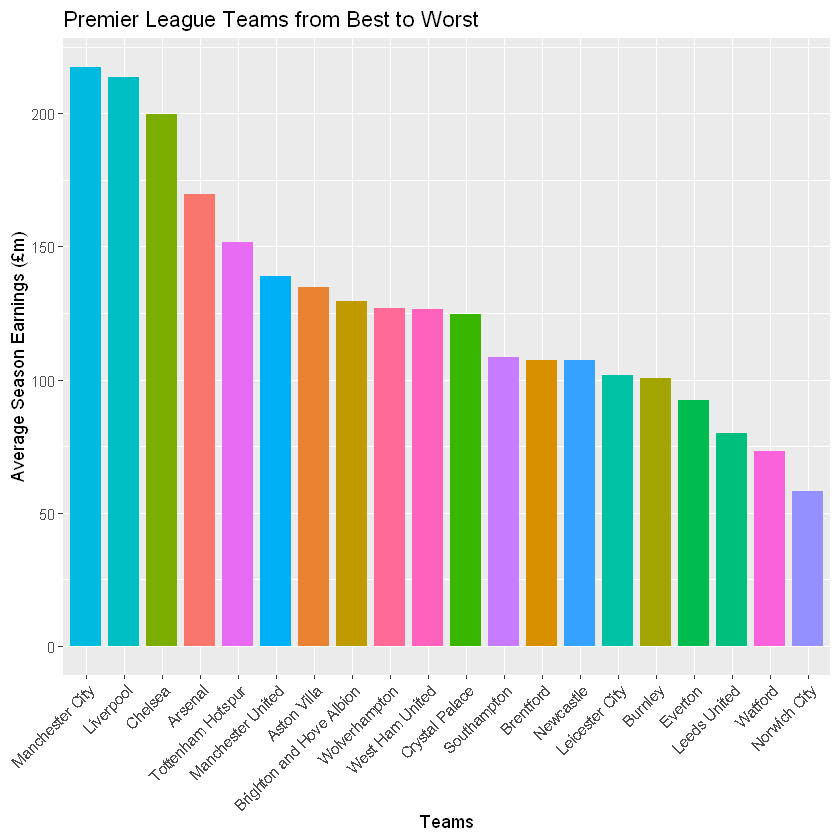

In [6]:
# Visualize rankings/earnings
ggplot(df.analysis, aes(x=reorder(team_names,-avg_prize), y=avg_prize, fill=team_names)) + 
  geom_bar(stat = "identity", width=0.8) +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) +
  xlab('Teams') +
  ylab('Average Season Earnings (£m)') +
  ggtitle('Premier League Teams from Best to Worst') +
  theme(legend.position="none")

***2. Which teams have the most variability in their simulated earnings?***
Leeds, Watford and Everton (based off of IQR metric)

Visualizing the range of earnings per team:
Resistance measure (interquartile range)

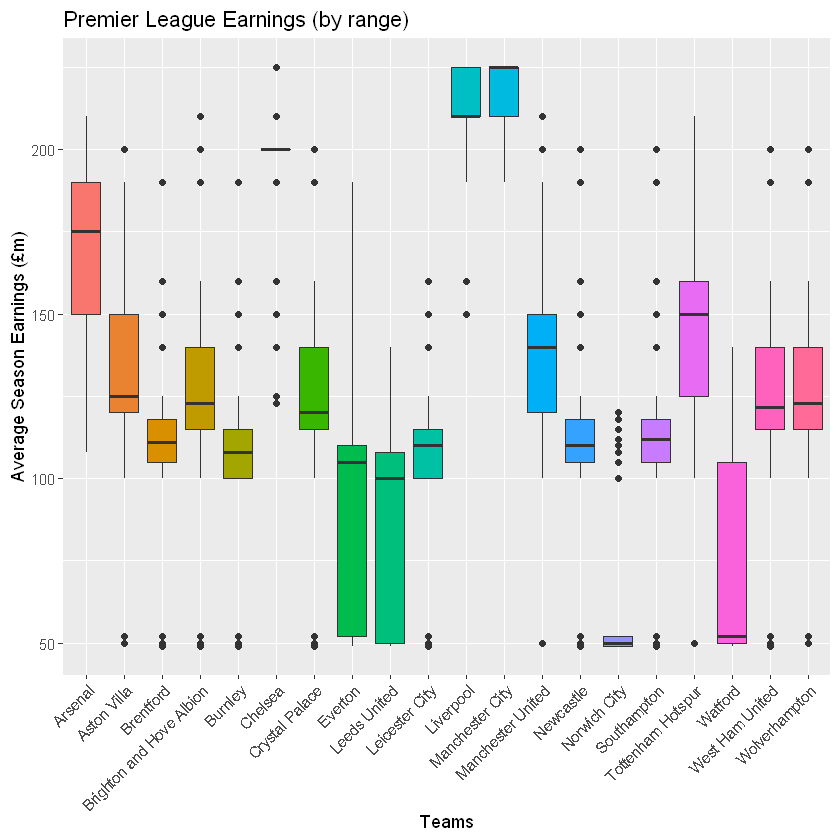

In [8]:
ggplot(df.summary, aes(x=team_names, y=prize, fill=team_names)) +
    geom_boxplot() +
    theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    xlab('Teams') +
    ylab('Average Season Earnings (£m)') +
    ggtitle('Premier League Earnings (by range)') +
    theme(legend.position="none")

Standard deviation (sensitive measure):
Less preferable since it's sensitive to outliers

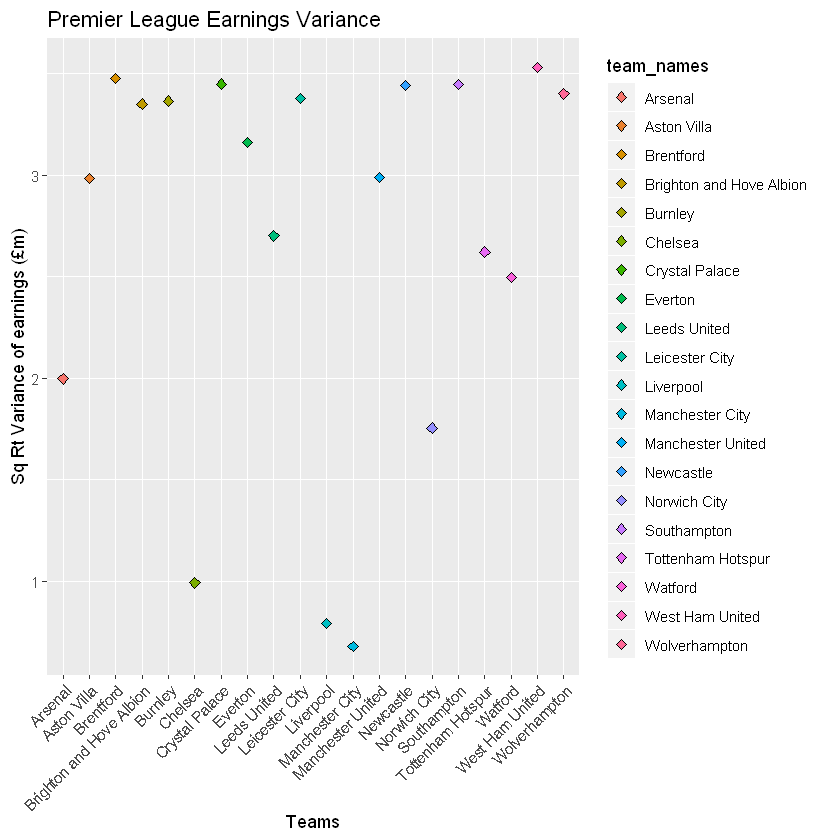

In [29]:
ggplot(df.analysis, aes(x=team_names, y=variability, fill=team_names)) +
  geom_point(size=2, shape=23) +
    theme(axis.text.x = element_text(angle = 45, hjust=1)) +
    xlab('Teams') +
    ylab('Sq Rt Variance of earnings (£m)') +
    ggtitle('Premier League Earnings Variance')

***3. Which teams stand to benefit the most in monetary terms from a "lucky win" (converting one of their losses to a win)? (visualization of marginal effect)***
Leeds, Everton and Watford

In [11]:
# clean appropriate variables
df.summary$prize <- as.numeric(df.summary$prize)
df.summary$points <- as.numeric(df.summary$points)
df.summary$goals_for <- as.numeric(df.summary$goals_for)
df.summary$goals_against <- as.numeric(df.summary$goals_against)
df.summary$net_goals <- as.numeric(df.summary$net_goals)
df.summary$tie_breaker <- as.numeric(df.summary$tie_breaker)
df.summary$team.f <- factor(df.summary$team_names)

reg1 <- lm(prize ~ points + team.f + team.f*points, data=df.summary) 
summary(reg1)


Call:
lm(formula = prize ~ points + team.f + team.f * points, data = df.summary)

Residuals:
    Min      1Q  Median      3Q     Max 
-51.185  -6.855   0.547   8.002  54.106 

Coefficients:
                                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)                           -20.46427    3.53041  -5.797 6.87e-09 ***
points                                  2.97225    0.05481  54.225  < 2e-16 ***
team.fAston Villa                       5.82190    4.70857   1.236 0.216306    
team.fBrentford                        14.29560    4.28664   3.335 0.000855 ***
team.fBrighton and Hove Albion         13.53503    4.51321   2.999 0.002712 ** 
team.fBurnley                          -2.75810    4.21839  -0.654 0.513230    
team.fChelsea                         109.92989    5.54830  19.813  < 2e-16 ***
team.fCrystal Palace                   20.05741    4.46896   4.488 7.22e-06 ***
team.fEverton                         -13.08015    4.16169  -3.143 0.001675 ** 
team.fLee

In [13]:
points1 <- rep(3, 20)
newdata1 <- data.frame(points1)
names(newdata1)[names(newdata1) == 'points1'] <- 'points'
newdata1$team.f <- df.summary$team.f[1:20]
newdata1$prize <- predict(reg1, newdata1)

points2 <- rep(0, 20)
newdata2 <- data.frame(points2)
names(newdata2)[names(newdata2) == 'points2'] <- 'points'
newdata2$team.f <- df.summary$team.f[1:20]
newdata2$prize <- predict(reg1, newdata2)

newdata1$prize_change <- newdata1$prize - newdata2$prize

newdata1

points,team.f,prize,prize_change
3,Manchester City,139.8406790,2.820037
3,Liverpool,124.2086851,3.335023
3,Chelsea,93.8499965,4.384373
3,Arsenal,-11.5475209,8.916750
3,Tottenham Hotspur,-26.0501746,9.513221
3,Manchester United,-11.2906612,8.596813
3,Aston Villa,-6.3690954,8.273273
3,West Ham United,2.5296237,7.737670
3,Brighton and Hove Albion,0.9184412,7.847677
3,Crystal Palace,7.0453340,7.452198


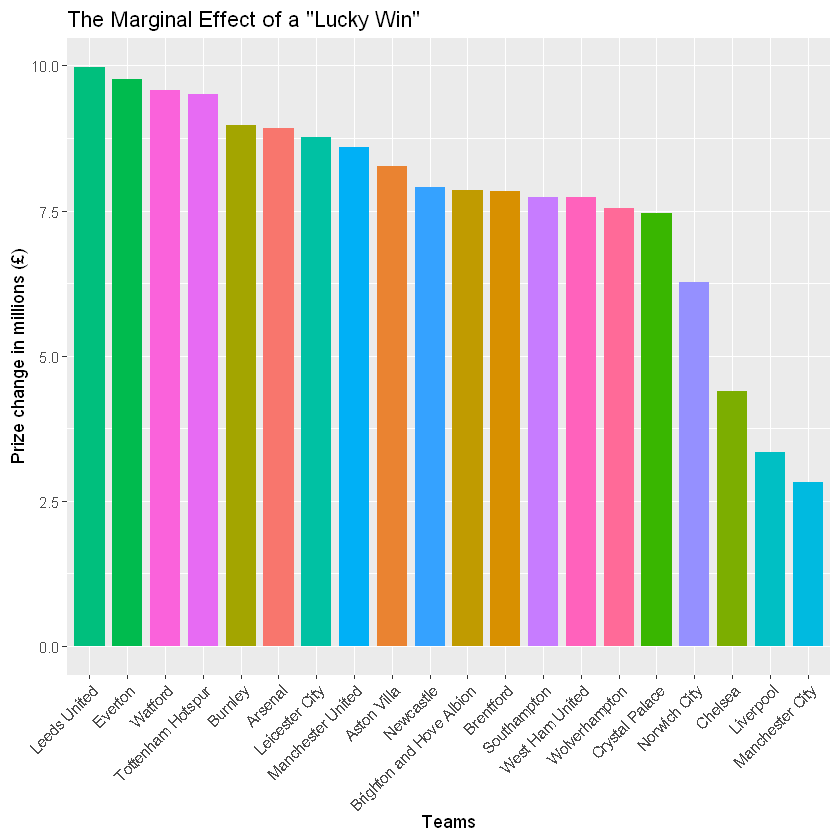

In [14]:
ggplot(newdata1, aes(x=reorder(team.f,-prize_change), y=prize_change, fill=team.f)) + 
  geom_bar(stat = "identity", width=0.8) +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) +
  xlab('Teams') +
  ylab('Prize change in millions (£)') +
  ggtitle('The Marginal Effect of a "Lucky Win"') +
  theme(legend.position="none")

***4. Finally, for each team, calculate the monetary benefit to each team from either 
    (i) an increase of 10% to their expected goals scored (holding everyone else constant), or 
    (ii) a decreasing in their expected goals conceded by 10% (Note that this means 40 separate simulations!)***
    
    Use this to provide a clear visualization of the benefits of investing in offense versus defense by team

In [24]:
# an increase of 10% to the expected goals scored
df.offense <- data.frame(matrix(ncol = 0, nrow = 0))

for (i in 1:20) {
    # increasing goals scored by 10%
    df.prem[i,1] = df.prem[i,1]*1.1

    # build parameters
    lmean.def<- log(mean(df.prem$def))
    lmean.off<- log(mean(df.prem$off))               
    df.prem["alpha"]<-log(df.prem["off"])-lmean.def
    df.prem["delta"]<-lmean.off-log(df.prem["def"])
    alphaList<-df.prem$alpha
    deltaList<-df.prem$delta
    names(alphaList)<-rownames(df.prem)
    names(deltaList)<-rownames(df.prem)

    # simulation (with one team changed)
    df.sim.earnings <- SeasonSim(allMatches)
    df.sim.earnings$team_change <- rownames(df.prem)[i]
    df.offense <- rbind(df.offense, df.sim.earnings)
}

head(df.offense)

points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,team_change
79,96,51,Manchester City,45,0.7876436,1,1,1.0,1.0,1,225,Manchester City
74,93,60,Liverpool,33,0.6509236,3,3,2.5,2.0,3,200,Manchester City
78,89,56,Chelsea,33,0.3065557,2,2,2.5,3.0,2,210,Manchester City
72,82,56,Arsenal,26,0.6771965,4,4,4.0,6.5,4,190,Manchester City
59,76,71,Tottenham Hotspur,5,0.6625444,6,6,7.5,12.0,6,150,Manchester City
63,82,71,Manchester United,11,0.9997283,5,5,5.0,6.5,5,160,Manchester City


In [26]:
# a decreasing in the expected goals conceded by 10%
df.defense <- data.frame(matrix(ncol = 0, nrow = 0))

for (i in 1:20) {
    # decreasing goals conceded by 10%
    df.prem[i,2] = df.prem[i,2]*.9

    # build parameters
    lmean.def<- log(mean(df.prem$def))
    lmean.off<- log(mean(df.prem$off))               
    df.prem["alpha"]<-log(df.prem["off"])-lmean.def
    df.prem["delta"]<-lmean.off-log(df.prem["def"])
    alphaList<-df.prem$alpha
    deltaList<-df.prem$delta
    names(alphaList)<-rownames(df.prem)
    names(deltaList)<-rownames(df.prem)

    # simulation (with one team changed)
    df.sim.earnings <- SeasonSim(allMatches)
    df.sim.earnings$team_change <- rownames(df.prem)[i]
    df.defense <- rbind(df.defense, df.sim.earnings)
}

head(df.defense)

points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,team_change
78,97,49,Manchester City,48,0.953606874,2.0,2,1.0,1.0,2,210,Manchester City
75,82,59,Liverpool,23,0.294027719,3.0,3,3.0,4.5,3,200,Manchester City
82,92,52,Chelsea,40,0.395935900,1.0,1,2.0,2.0,1,225,Manchester City
60,82,67,Arsenal,15,0.008559191,6.5,6,5.0,4.5,6,150,Manchester City
63,81,72,Tottenham Hotspur,9,0.823518864,4.5,5,6.0,7.0,5,160,Manchester City
57,76,76,Manchester United,0,0.674384865,8.0,8,10.5,11.0,8,125,Manchester City


In [27]:
offense <- data.frame(matrix(ncol = 0, nrow = 0))
defense <- data.frame(matrix(ncol = 0, nrow = 0))

for (i in 1:400){
    if (df.offense[i, 4] == df.offense[i, 13]){
        offense <- rbind(offense, df.offense[i,])
    }
    if (df.defense[i, 4] == df.defense[i, 13]){
        defense <- rbind(defense, df.defense[i,])
    }
}

offense
defense

,points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,team_change
1,79,96,51,Manchester City,45,0.78764360,1.0,1,1.0,1.0,1,225,Manchester City
22,89,103,50,Liverpool,53,0.92206075,2.0,2,2.0,2.0,2,210,Liverpool
43,82,95,52,Chelsea,43,0.57269264,3.0,3,3.0,3.0,3,200,Chelsea
64,85,97,54,Arsenal,43,0.75023077,3.0,3,3.0,3.0,3,200,Arsenal
85,60,84,71,Tottenham Hotspur,13,0.03492842,5.5,5,5.0,3.0,5,160,Tottenham Hotspur
106,57,81,76,Manchester United,5,0.40361303,7.0,7,10.0,6.0,7,140,Manchester United
127,65,90,79,Aston Villa,11,0.23672710,5.0,5,7.0,3.0,5,160,Aston Villa
148,50,81,76,West Ham United,5,0.50529400,11.0,11,8.0,7.5,11,118,West Ham United
169,56,78,70,Brighton and Hove Albion,8,0.99387407,8.0,8,6.0,9.5,8,125,Brighton and Hove Albion
190,58,76,71,Crystal Palace,5,0.71953275,6.0,6,6.0,8.0,6,150,Crystal Palace


,points,goals_for,goals_against,team_names,net_goals,tie_breaker,temp_team_rank,temp_team_rank2,goals_rank,goalsfor_rank,team_rank,prize,team_change
1,78,97,49,Manchester City,48,0.9536069,2.0,2,1.0,1.0,2,210,Manchester City
22,81,87,51,Liverpool,36,0.3628986,2.0,2,2.0,2.0,2,210,Liverpool
43,78,89,51,Chelsea,38,0.5939528,3.0,3,3.0,5.0,3,200,Chelsea
64,67,86,65,Arsenal,21,0.2276323,4.0,4,4.0,4.0,4,190,Arsenal
85,52,86,77,Tottenham Hotspur,9,0.3126648,9.0,9,8.0,4.0,9,123,Tottenham Hotspur
106,64,86,63,Manchester United,23,0.4541163,6.0,6,4.0,4.0,6,150,Manchester United
127,47,80,80,Aston Villa,0,0.3161886,11.0,11,9.5,5.5,11,118,Aston Villa
148,66,78,69,West Ham United,9,0.7343185,4.5,5,6.0,7.5,5,160,West Ham United
169,56,78,75,Brighton and Hove Albion,3,0.6474370,8.0,8,9.0,8.0,8,125,Brighton and Hove Albion
190,40,77,78,Crystal Palace,-1,0.7167629,15.5,15,10.0,8.0,15,108,Crystal Palace


In [28]:
df.change <- df.analysis
df.change$inc_change <- offense$prize
df.change$dec_change <- defense$prize
df.change$inc_change_diff <- df.change$inc_change - df.change$avg_prize
df.change$dec_change_diff <- df.change$dec_change - df.change$avg_prize

df.change

team_names,avg_rank,avg_prize,variability,inc_change,dec_change,inc_change_diff,dec_change_diff
Manchester City,1.544,217.340,0.6800930,225,210,7.660,-7.340
Liverpool,1.837,213.455,0.7918700,210,210,-3.455,-3.455
Chelsea,2.960,199.528,0.9926658,200,200,0.472,0.472
Arsenal,5.102,169.730,1.9973947,200,190,30.270,20.270
Tottenham Hotspur,6.545,151.809,2.6212298,160,123,8.191,-28.809
Manchester United,7.938,139.059,2.9874874,140,150,0.941,10.941
Aston Villa,8.429,134.613,2.9832631,160,118,25.387,-16.613
West Ham United,9.815,126.549,3.5303312,118,160,-8.549,33.451
Brighton and Hove Albion,9.321,129.398,3.3504006,125,125,-4.398,-4.398
Crystal Palace,10.066,124.800,3.4492813,150,108,25.200,-16.800


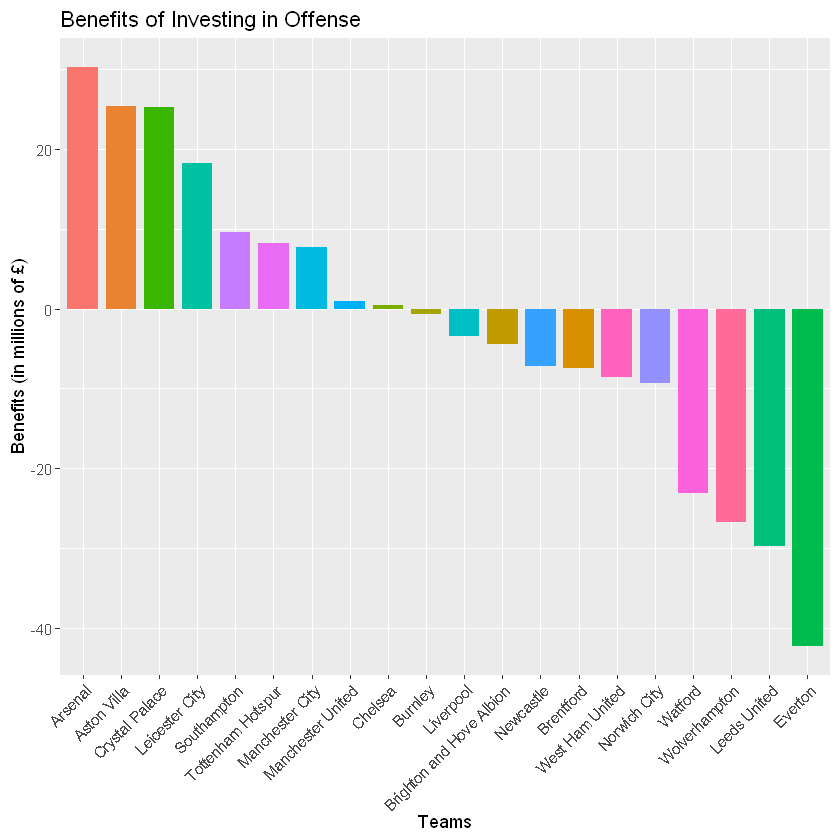

In [31]:
ggplot(df.change, aes(x=reorder(team_names,-inc_change_diff), y=inc_change_diff, fill=team_names)) + 
  geom_bar(stat = "identity", width=0.8) +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) +
  xlab('Teams') +
  ylab('Benefits (in millions of £)') +
  ggtitle('Benefits of Investing in Offense') +
  theme(legend.position="none")

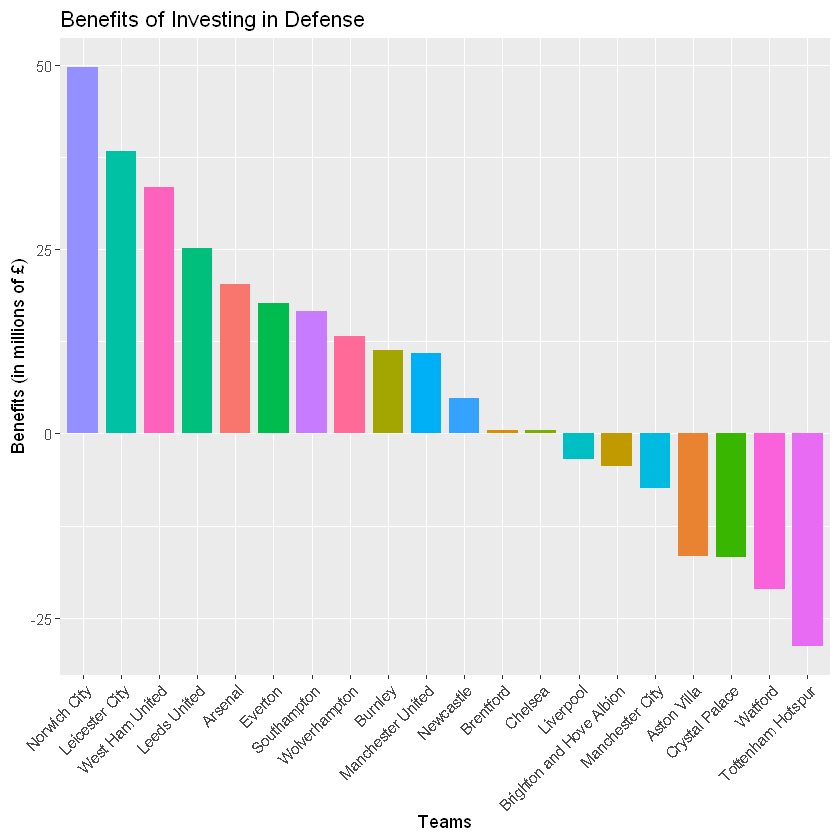

In [32]:
ggplot(df.change, aes(x=reorder(team_names,-dec_change_diff), y=dec_change_diff, fill=team_names)) + 
  geom_bar(stat = "identity", width=0.8) +
  theme(axis.text.x = element_text(angle = 45, hjust=1)) +
  xlab('Teams') +
  ylab('Benefits (in millions of £)') +
  ggtitle('Benefits of Investing in Defense') +
  theme(legend.position="none")